In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import random

# a

## آ)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
classes = ('plane', 'car')
class_indices = [i for i, lbl in enumerate(trainset.targets) if lbl in [0, 1]]
filtered_data = torch.utils.data.Subset(trainset, class_indices)

trainloader = torch.utils.data.DataLoader(filtered_data, batch_size=64,
                                          shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 41577870.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Loss: 0.248, Accuracy: 89.33%
Epoch [2/10] Loss: 0.074, Accuracy: 97.41%
Epoch [3/10] Loss: 0.036, Accuracy: 98.72%
Epoch [4/10] Loss: 0.017, Accuracy: 99.54%
Epoch [5/10] Loss: 0.017, Accuracy: 99.42%
Epoch [6/10] Loss: 0.007, Accuracy: 99.84%
Epoch [7/10] Loss: 0.007, Accuracy: 99.78%
Epoch [8/10] Loss: 0.007, Accuracy: 99.83%
Epoch [9/10] Loss: 0.004, Accuracy: 99.89%
Epoch [10/10] Loss: 0.004, Accuracy: 99.85%


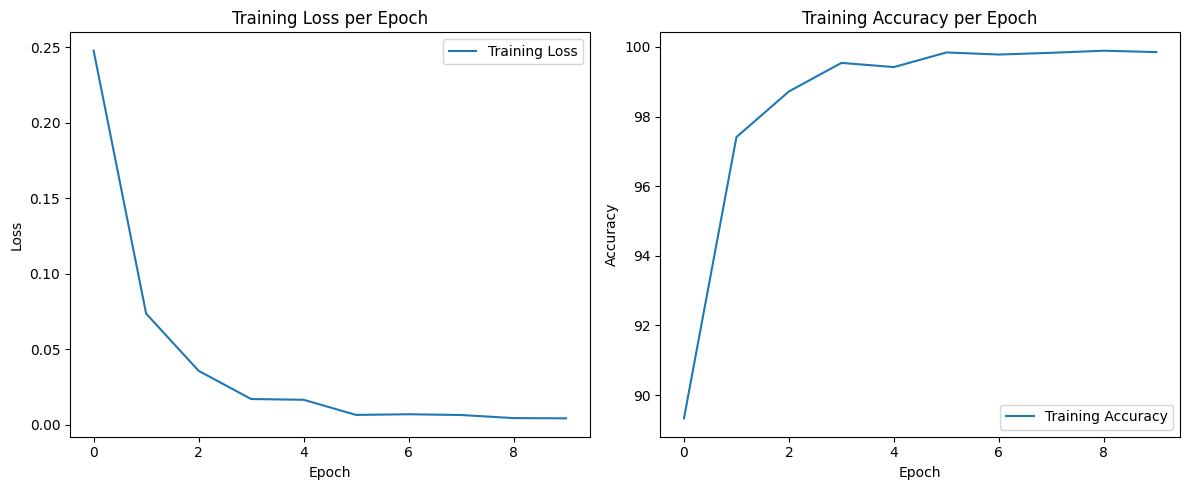

In [ ]:
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

loss_values = []
accuracy_values = []

for epoch in range(10):
    running_loss = 0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    loss_values.append(running_loss / len(trainloader))
    accuracy_values.append(100 * correct / total)

    print(f'Epoch [{epoch + 1}/10] Loss: {loss_values[-1]:.3f}, Accuracy: {accuracy_values[-1]:.2f}%')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## ب)

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

classes = ('plane', 'car')
class_indices = [i for i, lbl in enumerate(testset.targets) if lbl in [0, 1]]
filtered_data = torch.utils.data.Subset(testset, class_indices)

testloader = torch.utils.data.DataLoader(filtered_data, batch_size=64,
                                          shuffle=True, num_workers=2)
# Evaluate model on test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy on test set
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Files already downloaded and verified
Accuracy on test set: 96.70%


# b

### آ)

In [4]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)  # Compute L2 distance for positive pair
        distance_negative = (anchor - negative).pow(2).sum(1)  # Compute L2 distance for negative pair
        losses = torch.relu(distance_positive - distance_negative + self.margin)  # Compute triplet loss
        return losses.mean()

### ب)

In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

    def forward(self, x):
        return self.resnet(x)


Epoch [1/10] Loss: 10.564
Epoch [2/10] Loss: 3.547
Epoch [3/10] Loss: 2.838
Epoch [4/10] Loss: 2.560
Epoch [5/10] Loss: 4.116
Epoch [6/10] Loss: 2.892
Epoch [7/10] Loss: 2.054
Epoch [8/10] Loss: 1.918
Epoch [9/10] Loss: 2.686
Epoch [10/10] Loss: 1.663


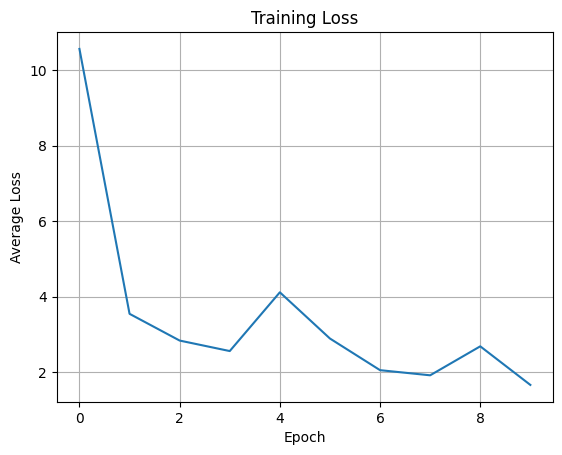

In [ ]:
feature_extractor = FeatureExtractor()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)

triplet_loss_fn = TripletLoss()

optimizer_feature_extractor = optim.SGD(feature_extractor.parameters(), lr=0.001, momentum=0.9)
loss_values = []

for epoch in range(10):
    epoch_loss = []
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        anchors, positives, negatives = [], [], []

        for i in range(len(images)):
            anchor, anchor_label = images[i], labels[i]
            anchor_class = anchor_label.item()

            # Choose a positive sample from the same class
            positive_candidates = [(images[idx], labels[idx]) for idx in range(len(images)) if labels[idx] == anchor_class and idx != i]
            if positive_candidates:
                positive_data, positive_label = random.choice(positive_candidates)
                positives.append(positive_data)
            else:
                continue

            # Choose a negative sample from a different class
            negative_candidates = [(images[idx], labels[idx]) for idx in range(len(images)) if labels[idx] != anchor_class]
            if negative_candidates:
                negative_data, negative_label = random.choice(negative_candidates)
                negatives.append(negative_data)
            else:
                continue

            anchors.append(anchor)

        if len(anchors) > 0 and len(positives) > 0 and len(negatives) > 0:
            anchors = torch.stack(anchors)
            positives = torch.stack(positives)
            negatives = torch.stack(negatives)

            optimizer_feature_extractor.zero_grad()
            features_anchor = feature_extractor(anchors)
            features_positive = feature_extractor(positives)
            features_negative = feature_extractor(negatives)

            loss = triplet_loss_fn(features_anchor, features_positive, features_negative)
            loss.backward()
            optimizer_feature_extractor.step()

            running_loss += loss.item()

    loss_values.append(running_loss / len(trainloader))
    print(f'Epoch [{epoch + 1}/10] Loss: {loss_values[-1]:.3f}')


plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

Epoch [1/30] Loss: 0.693, Accuracy: 50.30%
Epoch [2/30] Loss: 0.689, Accuracy: 66.34%
Epoch [3/30] Loss: 0.686, Accuracy: 67.38%
Epoch [4/30] Loss: 0.683, Accuracy: 67.65%
Epoch [5/30] Loss: 0.680, Accuracy: 67.61%
Epoch [6/30] Loss: 0.678, Accuracy: 67.73%
Epoch [7/30] Loss: 0.675, Accuracy: 67.64%
Epoch [8/30] Loss: 0.672, Accuracy: 67.68%
Epoch [9/30] Loss: 0.670, Accuracy: 67.43%
Epoch [10/30] Loss: 0.668, Accuracy: 67.44%
Epoch [11/30] Loss: 0.665, Accuracy: 67.87%
Epoch [12/30] Loss: 0.663, Accuracy: 67.72%
Epoch [13/30] Loss: 0.661, Accuracy: 67.37%
Epoch [14/30] Loss: 0.659, Accuracy: 67.82%
Epoch [15/30] Loss: 0.657, Accuracy: 67.55%
Epoch [16/30] Loss: 0.656, Accuracy: 67.55%
Epoch [17/30] Loss: 0.654, Accuracy: 67.47%
Epoch [18/30] Loss: 0.652, Accuracy: 67.77%
Epoch [19/30] Loss: 0.651, Accuracy: 67.94%
Epoch [20/30] Loss: 0.649, Accuracy: 67.55%
Epoch [21/30] Loss: 0.648, Accuracy: 67.82%
Epoch [22/30] Loss: 0.647, Accuracy: 67.88%
Epoch [23/30] Loss: 0.645, Accuracy: 67.7

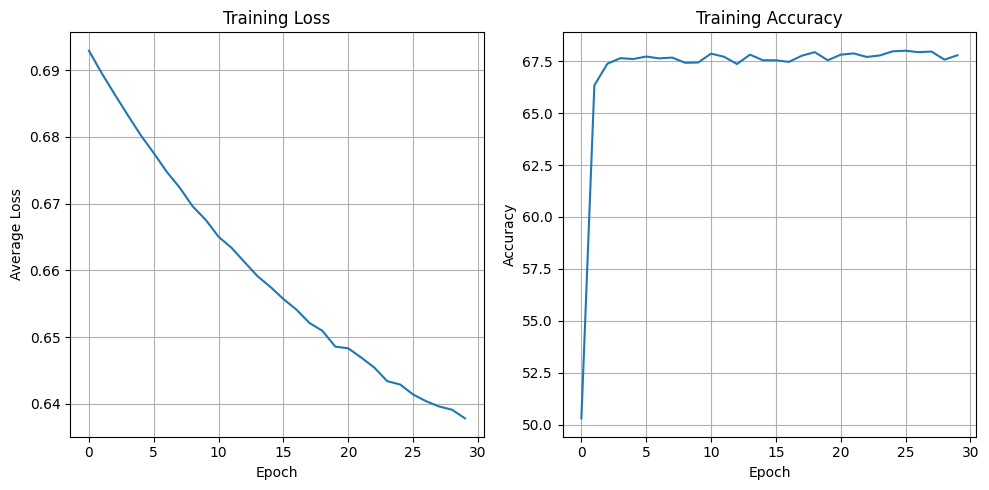

In [ ]:
class NewFC(nn.Module):
    def __init__(self, num_features_fc, num_classes):
        super(NewFC, self).__init__()
        self.fc = nn.Linear(num_features_fc, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x

for param in feature_extractor.parameters():
    param.requires_grad = False

num_classes = 2
num_features_fc = 2048
new_fc_layer = NewFC(num_features_fc, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_fc_layer.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_fc_layer.parameters(), lr=0.0002, momentum=0.9)
loss_values = []
accuracy_values = []

for epoch in range(30):
    running_loss = 0
    total = 0
    correct = 0

    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        features = feature_extractor(images)
        features = torch.flatten(features, start_dim=1)
        outputs = new_fc_layer(features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    loss_values.append(epoch_loss)
    accuracy_values.append(accuracy)

    print(f'Epoch [{epoch + 1}/30] Loss: {epoch_loss:.3f}, Accuracy: {accuracy:.2f}%')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

classes = ('plane', 'car')
class_indices = [i for i, lbl in enumerate(testset.targets) if lbl in [0, 1]]
filtered_data = torch.utils.data.Subset(testset, class_indices)

testloader = torch.utils.data.DataLoader(filtered_data, batch_size=64,
                                          shuffle=True, num_workers=2)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        features = feature_extractor(images)
        features = torch.flatten(features, start_dim=1)
        outputs = new_fc_layer(features)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Files already downloaded and verified
Accuracy on test set: 68.75%


# c

In [8]:
class NewFC(nn.Module):
    def __init__(self, num_features_fc, num_classes):
        super(NewFC, self).__init__()
        self.fc = nn.Linear(num_features_fc, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Total Loss: 14.153, Accuracy: 50.87%
Epoch [2/10] Total Loss: 4.615, Accuracy: 57.08%
Epoch [3/10] Total Loss: 3.319, Accuracy: 59.82%
Epoch [4/10] Total Loss: 3.142, Accuracy: 62.12%
Epoch [5/10] Total Loss: 3.255, Accuracy: 63.92%
Epoch [6/10] Total Loss: 3.704, Accuracy: 61.19%
Epoch [7/10] Total Loss: 3.475, Accuracy: 59.59%
Epoch [8/10] Total Loss: 2.793, Accuracy: 59.47%
Epoch [9/10] Total Loss: 3.279, Accuracy: 59.64%
Epoch [10/10] Total Loss: 3.045, Accuracy: 60.14%


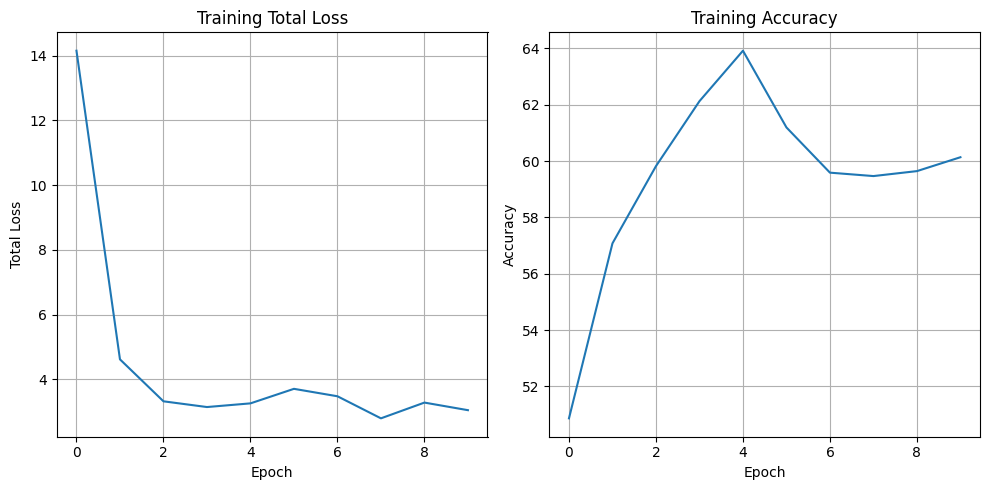

In [11]:
feature_extractor = FeatureExtractor()
num_classes = 2
num_features_fc = 2048
classifier = NewFC(num_features_fc, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)
classifier.to(device)

triplet_loss_fn = TripletLoss()
cross_entropy_loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(list(feature_extractor.parameters()) + list(classifier.parameters()), lr=0.001, momentum=0.9)

loss_values_total = []
accuracy_values = []
total=0
correct=0
for epoch in range(10):
    running_loss_triplet = 0
    running_loss_cross_entropy = 0
    running_loss_total = 0

    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        features = feature_extractor(images)
        features = torch.flatten(features, start_dim=1)

        anchors, positives, negatives = [], [], []
        for i in range(len(images)):
            anchor, anchor_label = images[i], labels[i]
            anchor_class = anchor_label.item()

            positive_candidates = [(images[idx], labels[idx]) for idx in range(len(images)) if labels[idx] == anchor_class and idx != i]
            if positive_candidates:
                positive_data, positive_label = random.choice(positive_candidates)
                positive_data_tensor = positive_data.to(device)
                positives.append(positive_data_tensor)
            else:
                continue

            negative_candidates = [(images[idx], labels[idx]) for idx in range(len(images)) if labels[idx] != anchor_class]
            if negative_candidates:
                negative_data, negative_label = random.choice(negative_candidates)
                negative_data_tensor = negative_data.to(device)
                negatives.append(negative_data_tensor)
            else:
                continue

            anchor_tensor = anchor.to(device)
            anchors.append(anchor_tensor)

        if len(anchors) > 0 and len(positives) > 0 and len(negatives) > 0:
            anchors = torch.stack(anchors)
            positives = torch.stack(positives)
            negatives = torch.stack(negatives)

            features_anchor = feature_extractor(anchors)
            features_positive = feature_extractor(positives)
            features_negative = feature_extractor(negatives)

            loss_triplet = triplet_loss_fn(features_anchor, features_positive, features_negative)

            outputs = classifier(features)
            loss_cross_entropy = cross_entropy_loss_fn(outputs, labels)

            alpha = 1
            beta = 1
            total_loss = alpha * loss_triplet + beta * loss_cross_entropy

            total_loss.backward()
            optimizer.step()

            running_loss_total += total_loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss_total = running_loss_total / len(trainloader)
    loss_values_total.append(epoch_loss_total)

    accuracy = 100 * correct / total
    accuracy_values.append(accuracy)

    print(f'Epoch [{epoch + 1}/10] Total Loss: {epoch_loss_total:.3f}, Accuracy: {accuracy:.2f}%')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values_total)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Total Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

classes = ('plane', 'car')
class_indices = [i for i, lbl in enumerate(testset.targets) if lbl in [0, 1]]
filtered_data = torch.utils.data.Subset(testset, class_indices)

testloader = torch.utils.data.DataLoader(filtered_data, batch_size=64,
                                          shuffle=True, num_workers=2)
correct = 0
total = 0
with torch.no_grad():

    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        features = feature_extractor(images)
        features = torch.flatten(features, start_dim=1)

        anchors, positives, negatives = [], [], []
        for i in range(len(images)):
            anchor, anchor_label = images[i], labels[i]
            anchor_class = anchor_label.item()

            positive_candidates = [(images[idx], labels[idx]) for idx in range(len(images)) if labels[idx] == anchor_class and idx != i]
            if positive_candidates:
                positive_data, positive_label = random.choice(positive_candidates)
                positive_data_tensor = positive_data.to(device)
                positives.append(positive_data_tensor)
            else:
                continue

            negative_candidates = [(images[idx], labels[idx]) for idx in range(len(images)) if labels[idx] != anchor_class]
            if negative_candidates:
                negative_data, negative_label = random.choice(negative_candidates)
                negative_data_tensor = negative_data.to(device)
                negatives.append(negative_data_tensor)
            else:
                continue

            anchor_tensor = anchor.to(device)
            anchors.append(anchor_tensor)

        if len(anchors) > 0 and len(positives) > 0 and len(negatives) > 0:
            anchors = torch.stack(anchors)
            positives = torch.stack(positives)
            negatives = torch.stack(negatives)

            features_anchor = feature_extractor(anchors)
            features_positive = feature_extractor(positives)
            features_negative = feature_extractor(negatives)

            loss_triplet = triplet_loss_fn(features_anchor, features_positive, features_negative)

            outputs = classifier(features)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Files already downloaded and verified
Accuracy on test set: 70.05%
